# P28 构建CNN
- CNN中的输入和层与传统有些区别，需要重新涉及，模块基本一致

In [13]:

import torch 
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import  DataLoader
import matplotlib as plt
import numpy as np
torch.__version__ 
%matplotlib inline




## Step 1 读取数据
- 分别构建训练集和测试集（验证）
- Dataloader 来迭代取数据


In [14]:
# 定义超参数
input_size = 28 # 图像总尺寸28*28
num_classes = 10 # 标签的种类数
num_epochs = 3 # 训练总循环周期
batch_size  = 128 # 批次大小

# 训练集
train_dataset = datasets.MNIST(root= '../data/',train = True, transform = transforms.ToTensor(),download = True)

# 测试集
test_dataset = datasets.MNIST(root= '../data/', train = False, transform = transforms.ToTensor())

# 构建batch数据
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True)

test_loader = DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle = True)

## Step 2 CNN——net


In [15]:
# 创建神经网络
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()   # 继承__init__功能
        self.conv1 = nn.Sequential(   # 输入（1 * 28 * 28)
            nn.Conv2d(
                in_channels=1,    # 灰度图
                out_channels=16,  # 要得到几个特征图
                kernel_size=5,    # 3x3的卷积核，相当于过滤器
                stride=1,         # 卷积核在图上滑动步长
                padding=2,        # 图边补0 ， padding = (kernel_size-1)/2 if stride = 1
            ),
            nn.ReLU(),            # Relu层
            nn.MaxPool2d(kernel_size=2)   # 经过池化 输出[16,14,14] 
        )
        # 第2层卷积
        self.conv2 = nn.Sequential(   # 输入（16 * 14 * 14)
            nn.Conv2d(
                in_channels=16,     
                out_channels=32,   
                kernel_size=5, 
                stride=1,        
                padding=2,       
            ),                        # 输出32 *14 * 14 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # 经过池化 输出[15,2,2] 传入下一个卷积
        )
        ## 输出层
        self.output = nn.Linear(32*7*7, 10) # 全连接层得到结果

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)           # [batch, 32,7,7]
        x = x.view(x.size(0), -1)   # 保留batch, 将后面的乘到一起 [batch, 32*7*7]
        output = self.output(x)     # 输出[50,10]
        return output

## Step 3 准确率评估


In [16]:
def accuracy(predictions,labels):
    pred = torch.max(predictions.data,1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights,len(labels)

##  Step 4 训练网络模型

In [19]:
from turtle import right


net = CNN()
# print(net) # 使用print(cnn)可以看到网络的结构详细信息，可以看到ReLU()也是一层layer

# 优化器 # optimizer 可以指定程序优化特定的选项，例如学习速率，权重衰减等
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001) # torch.optim是一个实现了多种优化算法的包
 
 
# loss_fun CrossEntropyLoss 交叉熵损失
# 信息量：它是用来衡量一个事件的不确定性的；一个事件发生的概率越大，不确定性越小，则它所携带的信息量就越小。
# 熵：它是用来衡量一个系统的混乱程度的，代表一个系统中信息量的总和；信息量总和越大，表明这个系统不确定性就越大。
# 交叉熵：它主要刻画的是实际输出（概率）与期望输出（概率）的距离，也就是交叉熵的值越小，两个概率分布就越接近
loss_func = nn.CrossEntropyLoss() # 该损失函数结合了nn.LogSoftmax()和nn.NLLLoss()两个函数 适用于分类
 
# training loop
for epoch in range(num_epochs):
    # 当前epoch 结果记录
    train_rights = []

    for batch_idx, (data, target) in enumerate(train_loader):
        net.train()
        output = net(data)
        loss = loss_func(output,target) # 计算误差 #　实际输出，　期望输出
        optimizer.zero_grad()           # 清空上一次梯度
        loss.backward()                 # 误差反向传递 只需要调用.backward()即可
        optimizer.step()                # cnn的优化器参数更新
        right = accuracy(output,target)
        train_rights.append(right)

        if batch_idx % 100 == 0:
            net.eval()
            val_rights = []
            for (data,target) in test_loader:
                output = net(data)  
                right = accuracy(output,target)
                val_rights.append(right)


            # 准确率计算
            train_r = (sum([tup[0] for tup in train_rights]) , sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]) ,sum([tup[1] for tup in val_rights]))

            print("当前epoch: {} [{}/{} {:.0f}%)]\t损失:{:.6f}\t训练集准确率:{:.2f}%\t测试集准确率:{:.2f}%".format(
                epoch, batch_idx * batch_size, len(train_loader.dataset), # type: ignore
                100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0].numpy() / train_r[1], # type: ignore
                100. * val_r[0].numpy() / val_r[1]) # type: ignore
                )


当前epoch: 0 [0/60000 0%)]	损失:2.298103	训练集准确率:14.45%	测试集准确率:9.79%
当前epoch: 0 [25600/60000 43%)]	损失:0.203937	训练集准确率:80.06%	测试集准确率:93.34%
当前epoch: 0 [51200/60000 85%)]	损失:0.170053	训练集准确率:87.36%	测试集准确率:96.32%
当前epoch: 1 [0/60000 0%)]	损失:0.132230	训练集准确率:96.48%	测试集准确率:96.63%
当前epoch: 1 [25600/60000 43%)]	损失:0.108245	训练集准确率:97.09%	测试集准确率:97.42%


KeyboardInterrupt: 

# P32 图像识别实战 flower

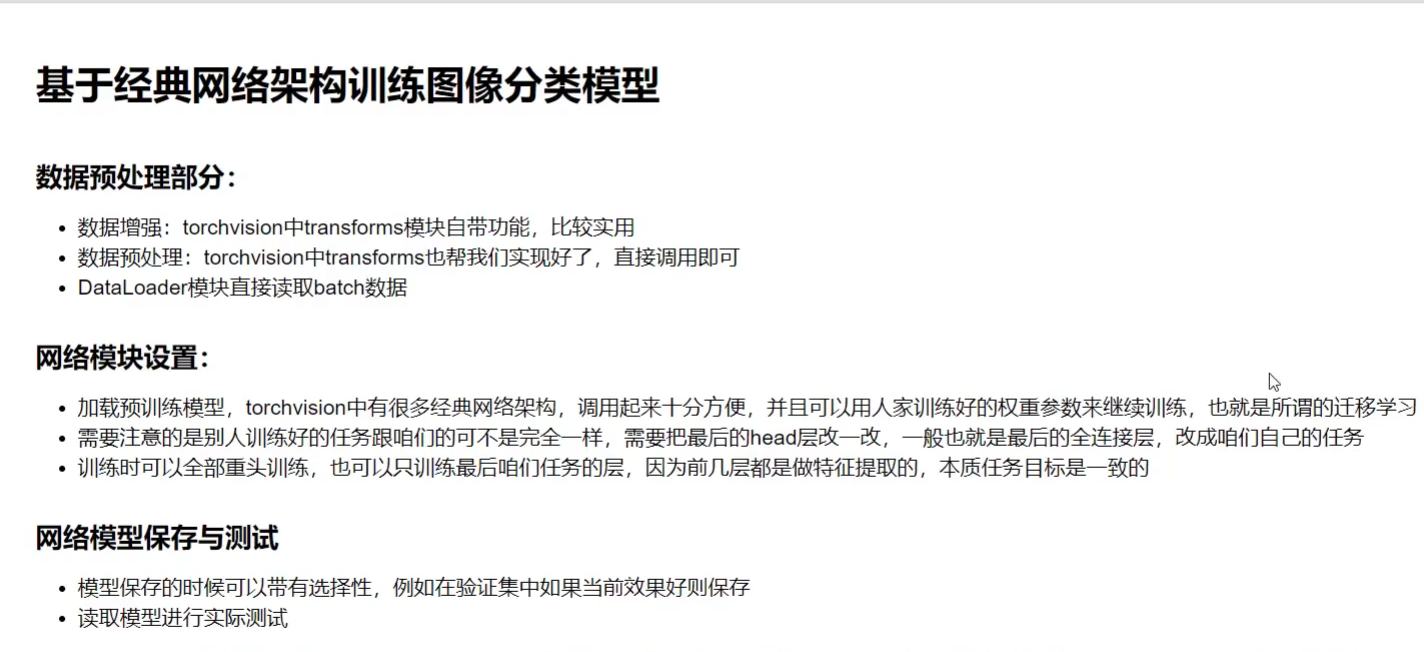

## P32 step 0 导入包  ResNet网络

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

import torch 
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms,models
from tensorflow import keras


torch.__version__ 


'2.1.0+cpu'

## Step 1 数据读取预处理


In [3]:
data_dir = '../data/flowers-102/dataset'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

data Augmentation ：数据增强 

In [4]:
data_transforms = {
    # 分成两部分，一部分是训练
    'train': transforms.Compose([transforms.RandomRotation(45), # 随机旋转 -45度到45度之间
                                 transforms.CenterCrop(224), # 从中心处开始裁剪
                                 # 以某个随机的概率决定是否翻转 55开
                                 transforms.RandomHorizontalFlip(p = 0.5), # 随机水平翻转
                                 transforms.RandomVerticalFlip(p = 0.5), # 随机垂直翻转
                                 # 参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
                                 transforms.ColorJitter(brightness = 0.2, contrast = 0.1, saturation = 0.1, hue = 0.1),
                                 transforms.RandomGrayscale(p = 0.025), # 概率转换为灰度图，三通道RGB
                                 # 灰度图转换以后也是三个通道，但是只是RGB是一样的
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值，标准差
                                ]),
    # resize成256 * 256 再选取 中心 224 * 224，然后转化为向量，最后正则化
    'valid': transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值和标准差和训练集相同
                                ]),
}


In [25]:
batch_size = 2
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']} 
class_names = image_datasets['train'].classes

#查看数据集合
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ../data/flowers-102/dataset\train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ../data/flowers-102/dataset\valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                N

In [26]:
# 验证一下数据是否已经被处理完毕
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2caedf7fe20>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x2caed615af0>}

In [27]:
dataset_sizes

{'train': 6552, 'valid': 818}

In [28]:
with open('../data/flowers-102/dataset/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [29]:
def im_convert(tensor):
    """数据展示"""
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    # 下面将图像还原，使用squeeze，将函数标识的向量转换为1维度的向量，便于绘图
    # transpose是调换位置，之前是换成了（c， h， w），需要重新还原为（h， w， c）
    image = image.transpose(1, 2, 0)
    # 反正则化（反标准化）
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    
    # 将图像中小于0 的都换成0，大于的都变成1
    image = image.clip(0, 1)
    
    return image


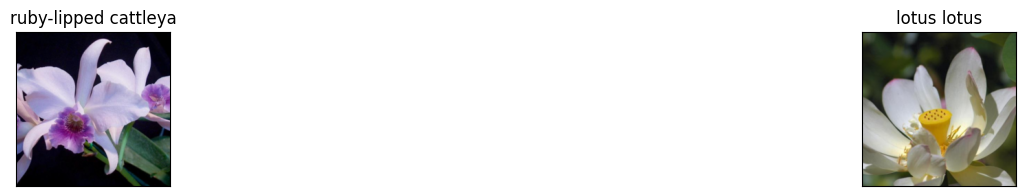

In [33]:
# 使用上面定义好的类进行画图
fig = plt.figure(figsize = (20, 2)) # type: ignore
columns = 2
rows = 1

# iter迭代器
# 随便找一个Batch数据进行展示
dataiter = iter(dataloaders['valid'])

inputs, classes = next(dataiter)

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks = [], yticks = [])
    # 利用json文件将其对应花的类型打印在图片中
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()



In [34]:
model_name = 'resnet' # 可选的模型比较多['resnet', 'alexnet', 'vgg', 'squeezenet', 'densent', 'inception']
# 主要的图像识别用resnet来做
# 是否用人家训练好的特征
feature_extract = True


In [35]:
# 是否用GPU进行训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.   Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')


CUDA is not available.   Training on CPU ...


In [36]:
# 将一些层定义为false，使其不自动更新
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [37]:
# 打印模型架构告知是怎么一步一步去完成的
# 主要是为我们提取特征的

model_ft = models.resnet152()
model_ft


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
# 将他人的模型加载进来
def initialize_model(model_name, num_classes, feature_extract, use_pretrained = True):
    # 选择适合的模型，不同的模型初始化参数不同
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """
        Resnet152
        """
        
        # 1. 加载与训练网络
        model_ft = models.resnet152(pretrained = use_pretrained)
        # 2. 是否将提取特征的模块冻住，只训练FC层
        set_parameter_requires_grad(model_ft, feature_extract)
        # 3. 获得全连接层输入特征
        num_frts = model_ft.fc.in_features
        # 4. 重新加载全连接层，设置输出102
        model_ft.fc = nn.Sequential(nn.Linear(num_frts, 102),
                                   nn.LogSoftmax(dim = 1)) # 默认dim = 0（对列运算），我们将其改为对行运算，且元素和为1
        input_size = 224

    elif model_name == "alexnet":
        """
        Alexnet
        """
        model_ft = models.alexnet(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)

        # 将最后一个特征输出替换 序号为【6】的分类器
        num_frts = model_ft.classifier[6].in_features # 获得FC层输入
        model_ft.classifier[6] = nn.Linear(num_frts, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """
        VGG11_bn
        """
        model_ft = models.vgg16(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_frts = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_frts, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """
        Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size = (1, 1), stride = (1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """
        Densenet
        """
        model_ft = models.desenet121(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_frts = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_frts, num_classes)
        input_size = 224

    elif model_name == "inception":
        """
        Inception V3
        """
        model_ft = models.inception_V(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)

        num_frts = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_frts, num_classes)

        num_frts = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_frts, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [39]:
# 设置模型名字、输出分类数
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained = True)

# GPU 计算
model_ft = model_ft.to(device)

# 模型保存, checkpoints 保存是已经训练好的模型，以后使用可以直接读取
filename = 'checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
# 打印出需要训练的层
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad ==True:
            print("\t", name)


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [40]:
# 优化器设置
optimizer_ft  = opt.Adam(params_to_update, lr = 1e-2)
# 学习率衰减策略
scheduler = opt.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# 学习率每7个epoch衰减为原来的1/10
# 最后一层使用LogSoftmax(), 故不能使用nn.CrossEntropyLoss()来计算

criterion = nn.NLLLoss()


In [41]:
# 定义训练函数
#is_inception：要不要用其他的网络
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False,filename=filename):
    since = time.time()
    #保存最好的准确率
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    #指定用GPU还是CPU
    model.to(device)
    #下面是为展示做的
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]
    #最好的一次存下来
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                #下面是将inputs,labels传到GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    #if这面不需要计算，可忽略
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                        #概率最大的返回preds
                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            #打印操作
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #模型保存
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    #tate_dict变量存放训练过程中需要学习的权重和偏执系数
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 保存训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 



In [42]:
#若太慢，把epoch调低，迭代50次可能好些
#训练时，损失是否下降，准确是否有上升；验证与训练差距大吗？若差距大，就是过拟合
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=5, is_inception=(model_name=="inception"))



Epoch 0/4
----------


KeyboardInterrupt: 

In [ ]:
# 将全部网络解锁进行训练
for param in model_ft.parameters():
    param.requires_grad = True
    
# 再继续训练所有的参数，学习率调小一点\
optimizer = opt.Adam(params_to_update, lr = 1e-4)
scheduler = opt.lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

# 损失函数
criterion = nn.NLLLoss()


In [ ]:
# 加载保存的参数
# 并在原有的模型基础上继续训练
# 下面保存的是刚刚训练效果较好的路径
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])


In [ ]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=2, is_inception=(model_name=="inception"))


In [ ]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU 模式
model_ft = model_ft.to(device) # 扔到GPU中

# 保存文件的名字
filename='checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
